# Final images

*27 Apr 2020*

This is the notebook for generating the final, corrected versions of the numerical power spectra.

In [28]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

from astropy import units as u
from helpers import ADD, make_mask, sigma_cr

## Mask

In [2]:
sharp_mask = make_mask(.3, .8, 500) # width .3 is a nicer graph
mask_coverage = np.sum(sharp_mask)/496**2

# Interlopers (500 pixels)
No need to run this cell.

In [3]:
# recover alpha matrix from cannon output files
job_outs = ['cannon_out/myoutput_54524676.out', 'cannon_out/myoutput_54737405.out', 'cannon_out/myoutput_54766264.out']
linums = []
datalines = [None] * 500
for job_out in job_outs:
    with open(job_out, 'r') as f:
        for line in f:
            lin = line.split()
            if len(lin) > 4 and lin[0] == 'finished' and lin[1] == 'row':
                linum = int(lin[2])
                datalines[linum] = eval(' '.join(lin[3:]))
                linums.append(linum)
datalines = np.array(datalines)

## ext 8.0 (mask illustration): `int_big`

In [4]:
newkappa = np.load('files/newkappa_int_ext8.0_theta7.0_pixnum500.npy')

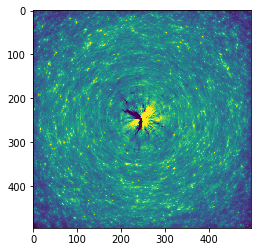

In [5]:
plt.imshow(newkappa, vmin=-1e-2, vmax=1e-2)

In [6]:
ext = 8.0
zl = 0.5
phys_width_kpc = 2 * ext * np.pi/648000  * ADD(0, zl).to(u.kpc).value
print(phys_width_kpc)

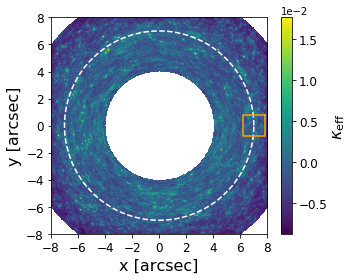

In [38]:
### Mask illustration ###
plt.figure(figsize=(5,4))

masked_kappa = newkappa * sharp_mask
for i in range(496):
    for j in range(496):
        if sharp_mask[i,j] == 0:
            masked_kappa[i,j] = float('nan')
plt.imshow(masked_kappa, extent=[-ext, ext, -ext, ext], aspect='equal')

## overplot Einstein ring ##
thetas = np.linspace(0, 2*np.pi, 100)
einst_rad = 7/8 * ext
xs = einst_rad * np.cos(thetas)
ys = einst_rad * np.sin(thetas)
plt.plot(xs, ys, linestyle='--', color='white')

## overplot small field-of-view square ##
def draw_square(sq_ctr, sq_size, color):
    x_signs = np.array([1, -1, -1, 1, 1])
    y_signs = np.array([1, 1, -1, -1, 1])
    plt.plot(sq_ctr[0] + sq_size*x_signs/2, sq_ctr[1] + sq_size*y_signs/2, color=color)

draw_square((einst_rad, 0), 2*ext/10, 'orange')
#draw_square((0, 0), phys_width_kpc, 'blue')


#plt.xlim(-phys_width_kpc/2, phys_width_kpc/2)

cbar = plt.colorbar()
cbar.set_label(r'$\kappa_\mathrm{eff}$', fontsize=16)
cbar.ax.tick_params(labelsize=12)
cbar.formatter.set_powerlimits((0,0))
cbar.ax.yaxis.set_offset_position('left') 
cbar.update_ticks()
plt.xlabel('x [arcsec]', fontsize=16)
plt.ylabel('y [arcsec]', fontsize=16)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.yticks(np.arange(-8,8.01,2))
plt.xticks(np.arange(-8,8.01,2))
plt.tight_layout()
plt.savefig('imgs/may28_mask.png')

In [68]:
np.save('files/int_big_mask.npy', newkappa * sharp_mask)

In [69]:
!~/python2 make_mask.py --pix_num=496 --side=101

In [70]:
!~/python2 power_spectrum.py \
--conv_file1 files/int_big_mask.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 101 \
--name int_big \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/int_big_mask.npy
k saved in files/kint_big_095_496_101.txt
saved files/ind_curves_int_big_095_496_101.npy


In [39]:
kint_big = np.loadtxt('files/kint_big_095_496_101.txt')
pint_big = np.load('files/ind_curves_int_big_095_496_101.npy')[0] / mask_coverage

## ext 0.8: `int_small`

In [24]:
kappa = np.load('files/newkappa_int_ext0.8_theta7.0_pixnum500.npy')

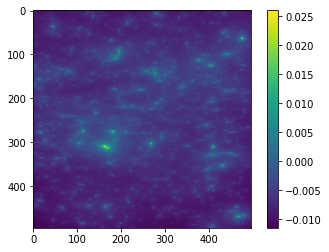

In [25]:
plt.imshow(kappa)
plt.colorbar()

In [13]:
!~/python2 make_mask.py --pix_num=496 --side=10

In [26]:
!~/python2 power_spectrum.py \
--conv_file1 files/newkappa_int_ext0.8_theta7.0_pixnum200.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 10 \
--name int_small \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/newkappa_int_ext0.8_theta7.0_pixnum200.npy
Traceback (most recent call last):
  File "power_spectrum.py", line 200, in <module>
    power_spectra,K = multipoles(tot_ps,kx,ky,mask=mask,pix_num=pix_num,dr=pix_size_k,ns=ns)
  File "/n/home13/atsang/interlopers/functions.py", line 308, in multipoles
    ring = data*j
ValueError: operands could not be broadcast together with shapes (196,196) (496,496) 


In [40]:
kint_small = np.loadtxt('files/kint_small_095_196_10.txt')
pint_small = np.load('files/ind_curves_int_small_095_196_10.npy')[0] # no mask anymore

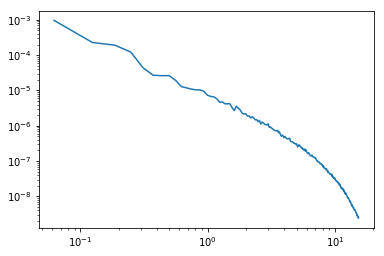

In [28]:
plt.loglog(kint_big, pint_big)

## Results (interlopers)

In [41]:
## Load analytic curve for comparison
theory_k = np.load('files/analytic_curves/1_ks_limber.npy')
theory_p = np.load('files/analytic_curves/1_powers_limber.npy')

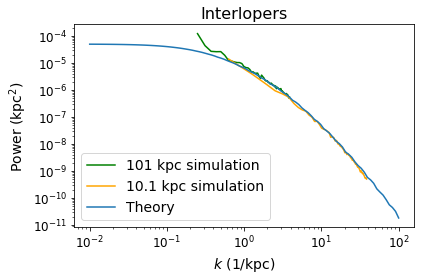

In [42]:
bigmin = 2*np.pi/101 * 4 # mask width
bigmax = 2*np.pi/(2/496*101) / 4 # Nyquist/stencil
smallmax = 2*np.pi/(2/496*10.1) / 4 # Nyquist/stencil

idxs_big = (kint_big >= bigmin) * (kint_big <= bigmax)
idxs_small = kint_small <= smallmax

kint_big_clip = kint_big[idxs_big]
pint_big_clip = pint_big[idxs_big]
kint_small_clip = kint_small[idxs_small]
pint_small_clip = pint_small[idxs_small]

plt.loglog(kint_big_clip, pint_big_clip, color='green', label='101 kpc simulation')
plt.loglog(kint_small_clip, pint_small_clip, color='orange', label='10.1 kpc simulation')
plt.loglog(theory_k, theory_p, label='Theory')

#plt.axvspan(smallmin, smallmax, color='orange', alpha=.15)
#plt.axvspan(2*np.pi/(1/4*101), 2*np.pi/(2/496*101), color='green', alpha=.15)

plt.legend(fontsize=14)
plt.gca().tick_params(labelsize=12)
plt.title('Interlopers', fontsize=16)

plt.xlabel('$k$ (1/kpc)', size=14)
plt.ylabel('Power (kpc$^2$)', size=14)
plt.tight_layout()

#plt.savefig('imgs/may11_interlopers.png')
#plt.savefig('imgs/may11_interlopers_alt.png')

# Subhalos (500 pix)

## ext 8.0: `sub_big`

First, recover the data from cannon files.

In [3]:
job_outs = ['cannon_out/myoutput_55262686.out']
linums = []
datalines = [None] * 500
for job_out in job_outs:
    with open(job_out, 'r') as f:
        for line in f:
            lin = line.split()
            if len(lin) > 4 and lin[0] == 'finished' and lin[1] == 'row':
                linum = int(lin[2])
                datalines[linum] = eval(' '.join(lin[3:]))
                linums.append(linum)
datalines = np.array(datalines)

In [5]:
datalines.shape

(500, 2, 500)

In [6]:
np.save('files/sub_pool_results.npy', datalines)

---

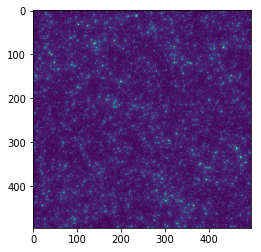

In [4]:
kappa = np.load('files/kappa_sub_ext8.0_pixnum500.npy')
plt.imshow(kappa)

In [76]:
!~/python2 power_spectrum.py \
--conv_file1 files/kappa_sub_ext8.0_pixnum500.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 101 \
--name sub_big \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/kappa_sub_ext8.0_pixnum500.npy
k saved in files/ksub_big_095_496_101.txt
saved files/ind_curves_sub_big_095_496_101.npy


In [43]:
ksub_big = np.loadtxt('files/ksub_big_095_496_101.txt')
psub_big = np.load('files/ind_curves_sub_big_095_496_101.npy')[0]

## ext 0.8: `sub_small`

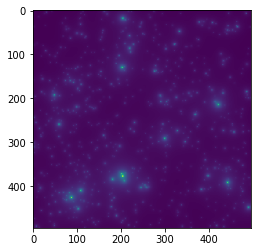

In [7]:
kappa = np.load('files/kappa_sub_ext0.8_pixnum500.npy')
plt.imshow(kappa)

In [85]:
!~/python2 power_spectrum.py \
--conv_file1 files/kappa_sub_ext0.8_pixnum500.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 10 \
--name sub_small \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/kappa_sub_ext0.8_pixnum500.npy
k saved in files/ksub_small_095_496_10.txt
saved files/ind_curves_sub_small_095_496_10.npy


In [44]:
ksub_small = np.loadtxt('files/ksub_small_095_496_10.txt')
psub_small = np.load('files/ind_curves_sub_small_095_496_10.npy')[0]

## Results (subhalos)

In [45]:
# subhalo mass between 10^5 and 10^8
ps_subhalos = np.array([[0.01, 0.000121064], [0.0125893, 0.000120882], [0.0158489, 
  0.000120614], [0.0199526, 0.000120224], [0.0251189, 
  0.000119661], [0.0316228, 0.000118854], [0.0398107, 
  0.00011771], [0.0501187, 0.00011611], [0.0630957, 
  0.000113904], [0.0794328, 0.000110919], [0.1, 
  0.000106968], [0.125893, 0.000101873], [0.158489, 
  0.0000955008], [0.199526, 0.0000878155], [0.251189, 
  0.0000789222], [0.316228, 0.0000690958], [0.398107, 
  0.0000587699], [0.501187, 0.0000484742], [0.630957, 
  0.0000387358], [0.794328, 0.0000299813], [1., 
  0.0000224772], [1.25893, 0.0000163215], [1.58489, 
  0.000011475], [1.99526, 7.80641e-6], [2.51189, 
  5.135e-6], [3.16228, 3.26397e-6], [3.98107, 
  2.00407e-6], [5.01187, 1.18868e-6], [6.30957, 
  6.81452e-7], [7.94328, 3.7796e-7], [10., 
  2.03083e-7], [12.5893, 1.05869e-7], [15.8489, 
  5.36262e-8], [19.9526, 2.6429e-8], [25.1189, 
  1.26873e-8], [31.6228, 5.93833e-9], [39.8107, 
  2.71258e-9], [50.1187, 1.21067e-9], [63.0957, 
  5.28754e-10], [79.4328, 2.2643e-10], [100., 
  9.53077e-11], [125.893, 3.95397e-11], [158.489, 
  1.62138e-11], [199.526, 6.58945e-12], [251.189, 
  2.66042e-12], [316.228, 1.06909e-12], [398.107, 
  4.28235e-13], [501.187, 1.71163e-13], [630.957, 
  6.83155e-14], [794.328, 2.72413e-14], [1000., 1.08562e-14]])
subtheory_k = ps_subhalos[:,0]
subtheory_p = ps_subhalos[:,1] * 1.902e5/1.906e6 * (3/3.11)**2 # this is Simon Birrer's normalization

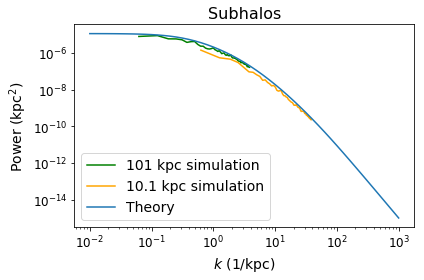

In [46]:
bigmax = 2*np.pi/(2/496*101) / 4  # Nyquist/stencil
smallmax = 2*np.pi/(2/496*10.1) / 4 # Nyquist/stencil

ksub_big_clip = ksub_big[ksub_big <= bigmax]
psub_big_clip = psub_big[ksub_big <= bigmax]
ksub_small_clip = ksub_small[ksub_small <= smallmax]
psub_small_clip = psub_small[ksub_small <= smallmax]

plt.loglog(ksub_big_clip, psub_big_clip, color='green', label='101 kpc simulation')
plt.loglog(ksub_small_clip, psub_small_clip, color='orange', label='10.1 kpc simulation')
plt.loglog(subtheory_k, subtheory_p, label='Theory')

plt.legend(fontsize=14)
plt.gca().tick_params(labelsize=12)
plt.title('Subhalos', fontsize=16)

plt.xlabel('$k$ (1/kpc)', size=14)
plt.ylabel('Power (kpc$^2$)', size=14)
plt.tight_layout()

#plt.savefig('imgs/may11_subhalos.png')

# Combined image
## ext 8.0

In [2]:
kappa = np.load('files/kappa_full_ext8.0_theta7.0.npy')

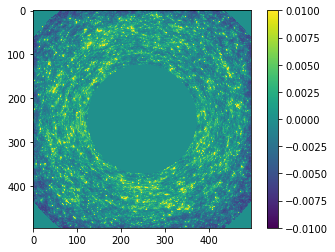

In [8]:
plt.imshow(sharp_mask * kappa, vmin=-.01, vmax=.01)
plt.colorbar()

In [9]:
np.save('files/full_big_mask.npy', sharp_mask * kappa)

In [10]:
!~/python2 make_mask.py --pix_num=496 --side=101

In [11]:
!~/python2 power_spectrum.py \
--conv_file1 files/full_big_mask.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 101 \
--name full_big \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/full_big_mask.npy
k saved in files/kfull_big_095_496_101.txt
saved files/ind_curves_full_big_095_496_101.npy


In [47]:
kfull_big = np.loadtxt('files/kfull_big_095_496_101.txt')
pfull_big = np.load('files/ind_curves_full_big_095_496_101.npy')[0]

---

In [12]:
kappa_small = np.load('files/kappa_full_ext0.8_theta7.0.npy')

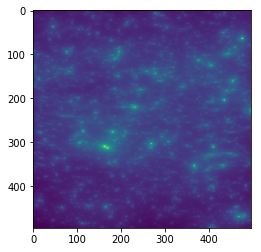

In [13]:
plt.imshow(kappa_small)

In [14]:
!~/python2 power_spectrum.py \
--conv_file1 files/kappa_full_ext0.8_theta7.0.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 10 \
--name full_small \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/kappa_full_ext0.8_theta7.0.npy
k saved in files/kfull_small_095_496_10.txt
saved files/ind_curves_full_small_095_496_10.npy


In [48]:
kfull_small = np.loadtxt('files/kfull_small_095_496_10.txt')
pfull_small = np.load('files/ind_curves_full_small_095_496_10.npy')[0]

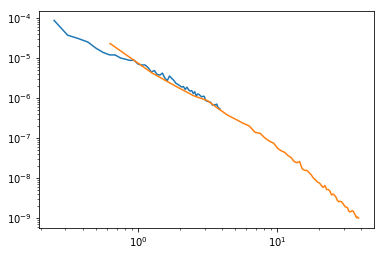

In [55]:
bigmin = 2*np.pi/101 * 4 # mask width
bigmax = 2*np.pi/(2/496*101) / 4 # Nyquist/stencil
smallmax = 2*np.pi/(2/496*10.1) / 4 # Nyquist/stencil

idxs_big = (kfull_big >= bigmin) * (kfull_big <= bigmax)
idxs_small = kfull_small <= smallmax

kfull_big_clip = kfull_big[idxs_big]
pfull_big_clip = pfull_big[idxs_big]
kfull_small_clip = kfull_small[idxs_small]
pfull_small_clip = pfull_small[idxs_small]

plt.loglog(kfull_big_clip, pfull_big_clip)
plt.loglog(kfull_small_clip, pfull_small_clip)

## Combined theory curve

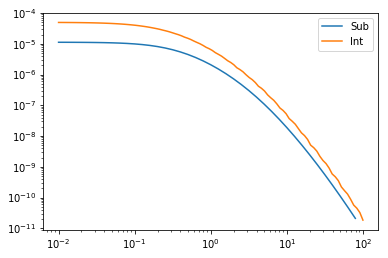

In [49]:
plt.loglog(subtheory_k[subtheory_k < 1e2], subtheory_p[subtheory_k < 1e2], label='Sub')
plt.loglog(theory_k, theory_p, label='Int')
plt.legend()

In [50]:
sub_interp = interp1d(subtheory_k, subtheory_p)
int_interp = interp1d(theory_k, theory_p)

In [51]:
fulltheory_k = theory_k
fulltheory_p = sub_interp(fulltheory_k) + int_interp(fulltheory_k)

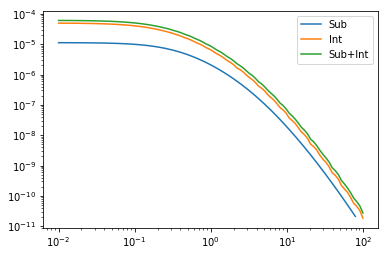

In [52]:
plt.loglog(subtheory_k[subtheory_k < 1e2], subtheory_p[subtheory_k < 1e2], label='Sub')
plt.loglog(theory_k, theory_p, label='Int')
plt.loglog(fulltheory_k, fulltheory_p, label='Sub+Int')
plt.legend()

In [53]:
## Calculate ratio ##
int_interp(1e-2)/sub_interp(1e-2)

4.415553577464903

# Final Image

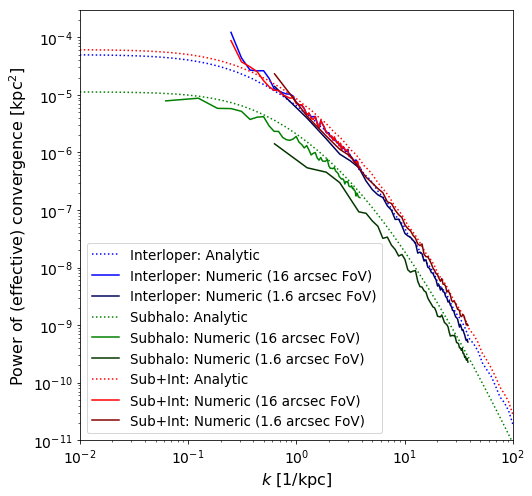

In [62]:
smallmin = 2*np.pi/(1/4*10.1)
smallmax = 2*np.pi/(2/496*10.1)
bigmin = 2*np.pi/(1/4*101)
bigmax = 2*np.pi/(2/496*101)

plt.figure(figsize=(7.5,7))

## interlopers ##
plt.loglog(theory_k, theory_p, color='blue', linestyle=':', label='Interloper: Analytic')
plt.loglog(kint_big_clip, pint_big_clip, color='blue', label='Interloper: Numeric (16 arcsec FoV)')
plt.loglog(kint_small_clip, pint_small_clip, color='xkcd:dark blue', label='Interloper: Numeric (1.6 arcsec FoV)')


#plt.axvspan(smallmin, smallmax, color='orange', alpha=.15)
#plt.axvspan(2*np.pi/(1/4*101), 2*np.pi/(2/496*101), color='green', alpha=.15)

## subhalos ##
plt.loglog(subtheory_k[subtheory_k < 2e2], subtheory_p[subtheory_k < 2e2], color='green', linestyle=':', label='Subhalo: Analytic')
plt.loglog(ksub_big_clip, psub_big_clip, color='green', linestyle='-', label='Subhalo: Numeric (16 arcsec FoV)')
plt.loglog(ksub_small_clip, psub_small_clip, color='xkcd:dark green', linestyle='-', label='Subhalo: Numeric (1.6 arcsec FoV)')


## full: interlopers + subhalos ##
plt.loglog(fulltheory_k, fulltheory_p, color='red', linestyle=':', label='Sub+Int: Analytic')
plt.loglog(kfull_big_clip, pfull_big_clip, color='red', label='Sub+Int: Numeric (16 arcsec FoV)')
plt.loglog(kfull_small_clip, pfull_small_clip, color='xkcd:dark red', label='Sub+Int: Numeric (1.6 arcsec FoV)')


plt.legend(fontsize=13.5)
plt.gca().tick_params(labelsize=14)
#plt.title('Subhalos and Interlopers separately', fontsize=16)
plt.xlim(1e-2, 1e2)
plt.ylim(1e-11, 3e-4)

plt.xlabel('$k$ [1/kpc]', size=16)
plt.ylabel('Power of (effective) convergence [kpc$^2$]', size=16)
plt.tight_layout()

#plt.savefig('imgs/may28_powers.png')

Old version:

ext 0.8 (small scale interlopers)

In [72]:
newkappa2 = np.load('files/newkappa_int_ext0.8_theta0.7_pixnum500.npy')

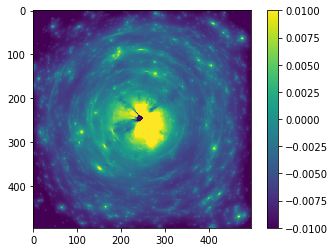

In [74]:
plt.imshow(newkappa2, vmin=-.01, vmax=.01)
plt.colorbar()

In [75]:
np.save('files/int_small_mask.npy', newkappa2 * sharp_mask)

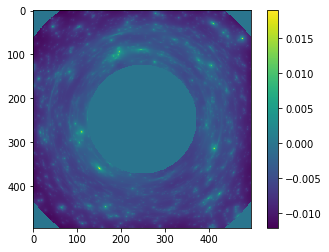

In [76]:
plt.imshow(newkappa2 * sharp_mask)
plt.colorbar()

In [77]:
!~/python2 power_spectrum.py \
--conv_file1 files/int_small_mask.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 10 \
--name int_small \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/int_small_mask.npy
k saved in files/kint_small_095_496_10.txt
saved files/ind_curves_int_small_095_496_10.npy


In [4]:
kint_small = np.loadtxt('files/kint_small_095_496_10.txt')
pint_small = np.load('files/ind_curves_int_small_095_496_10.npy')[0] / mask_coverage

---

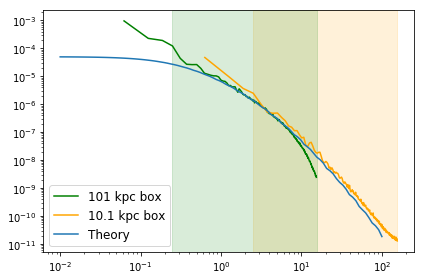

In [23]:
# plt.loglog(ksub_big, psub_big, color='purple')
# plt.loglog(ksub_small, psub_small, color='blue')
# plt.loglog(subtheory_k, subtheory_p)
plt.loglog(kint_big, pint_big, color='green', label='101 kpc box')
plt.loglog(kint_small, pint_small, color='orange', label='10.1 kpc box')
plt.loglog(theory_k, theory_p, label='Theory')

plt.axvspan(2*np.pi/(1/4*10.1), 2*np.pi/(2/496*10.1), color='orange', alpha=.15)
plt.axvspan(2*np.pi/(1/4*101), 2*np.pi/(2/496*101), color='green', alpha=.15)

plt.legend(fontsize=12)

plt.tight_layout()

# Old cells

# 200 pixels
## Interlopers -- ext 0.8

In [3]:
raw_small = np.load('files/newkappa_int_ext0.8_theta0.7_pixnum200.npy')

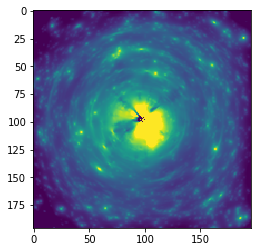

In [11]:
plt.imshow(raw_small, vmin=-.01, vmax=.01)

In [5]:
sharp_mask = make_mask(.1, .8, 200)
mask_coverage = np.sum(sharp_mask)/196**2

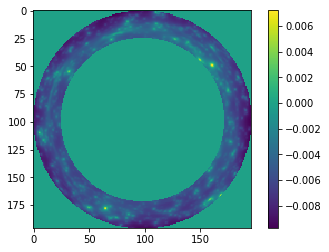

In [10]:
plt.imshow(raw_small * sharp_mask)
plt.colorbar()

In [12]:
np.save('files/raw_small_mask.npy', raw_small * sharp_mask)

In [2]:
ext = .8
zl = 0.5
phys_width_kpc = 2 * ext * np.pi/648000  * ADD(0, zl).to(u.kpc).value
print(phys_width_kpc)

10.072910564904317


In [3]:
zs = 1.0
sigma_cr(zl, zs).to(u.Msun/u.kpc**2)

<Quantity 3.00524458e+09 solMass / kpc2>

In [20]:
!~/python2 make_mask.py --pix_num=196 --side=10

In [26]:
!~/python2 power_spectrum.py \
--conv_file1 files/raw_small_mask.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 10 \
--name raw_small \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/raw_small_mask.npy
k saved in files/kraw_small_095_196_10.txt
saved files/ind_curves_raw_small_095_196_10.npy


In [6]:
kraw_small = np.loadtxt('files/kraw_small_095_196_10.txt')
praw_small = np.load('files/ind_curves_raw_small_095_196_10.npy')[0] / mask_coverage

## Interlopers -- ext 8

In [2]:
raw_big = np.load('files/newkappa_int_ext8.0_theta7.0_pixnum200.npy')

In [ ]:
plt.imshow(raw_big, vmin=-.01, vmax=.01)

In [ ]:
plt.imshow(raw_big * sharp_mask)
plt.colorbar()

In [9]:
np.save('files/raw_big_mask.npy', raw_big * sharp_mask)

In [30]:
ext = 8.0
zl = 0.5
phys_width_kpc = 2 * ext * np.pi/648000  * ADD(0, zl).to(u.kpc).value
print(phys_width_kpc)

100.72910564904318


In [11]:
!~/python2 make_mask.py --pix_num=196 --side=101

In [12]:
!~/python2 power_spectrum.py \
--conv_file1 files/raw_big_mask.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 101 \
--name raw_big \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/raw_big_mask.npy
k saved in files/kraw_big_095_196_101.txt
saved files/ind_curves_raw_big_095_196_101.npy


In [7]:
kraw_big = np.loadtxt('files/kraw_big_095_196_101.txt')
praw_big = np.load('files/ind_curves_raw_big_095_196_101.npy')[0] / mask_coverage

## Graphs

In [8]:
## Load analytic curve for comparison
theory_k = np.load('files/analytic_curves/1_ks_limber.npy')
theory_p = np.load('files/analytic_curves/1_powers_limber.npy')

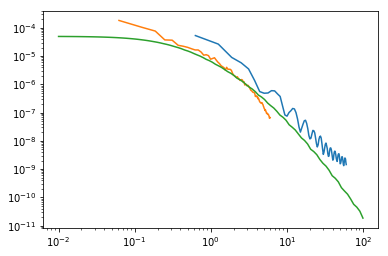

In [10]:
plt.loglog(kraw_small, praw_small)
plt.loglog(kraw_big, praw_big)
plt.loglog(theory_k, theory_p)

In [11]:
# load some old curves for comparison
k_500old = np.loadtxt('files/kp500_095_496_10.txt')
p_500old = np.load('files/ind_curves_p500_095_496_10.npy')[0] / mask_coverage # same mask
ke8_500old = np.loadtxt('files/kp500e8_095_496_97.txt')
pe8_500old = np.load('files/ind_curves_p500e8_095_496_97.npy')[0] / mask_coverage

ks_200old = np.loadtxt('files/ks{}_095_196_10.txt'.format(100))
ps_200old = np.load('files/ind_curves_s{}_095_196_10.npy'.format(100))[0] / mask_coverage
kse8_200old = np.loadtxt('files/ks{}e8_095_196_97.txt'.format(100))
pse8_200old = np.load('files/ind_curves_s{}e8_095_196_97.npy'.format(100))[0] / mask_coverage

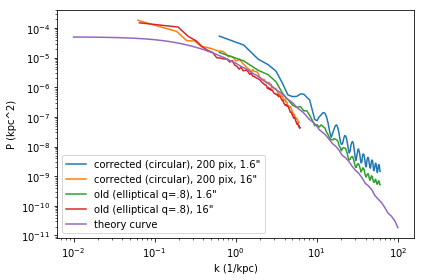

In [14]:
plt.loglog(kraw_small, praw_small, label='corrected (circular), 200 pix, 1.6"')
plt.loglog(kraw_big, praw_big, label='corrected (circular), 200 pix, 16"')
#plt.loglog(k_500old, p_500old, label='old (elliptical q=.8), 1.6"')
#plt.loglog(ke8_500old, pe8_500old, label='old (elliptical q=.8), 16"')
plt.loglog(ks_200old, ps_200old, label='old (elliptical q=.8), 1.6"')
plt.loglog(kse8_200old, pse8_200old, label='old (elliptical q=.8), 16"')
plt.loglog(theory_k, theory_p, label='theory curve')
plt.legend()
plt.xlabel('k (1/kpc)')
plt.ylabel('P (kpc^2)')
plt.tight_layout()